<center><h1>PUBG Player's Data Analysis and Placement Prediction</h1></center>
<center><h2>Fan Wang &nbsp;&nbsp;Bolun Yan </h2></center>
<center><h2>A53277514 &nbsp;&nbsp;A92413094 </h2></center>

In [1]:
# preparation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.filterwarnings("ignore")

<h1>Part 1 - Data Pre-process </h1>

In [2]:
# read data
train = pd.read_csv('data/train_v2.csv')
test = pd.read_csv('data/test_v2.csv')
print(train.shape)
print(test.shape)

(4446966, 29)


In [3]:
# show columns name
columns = list(train.columns.values)
print(columns)

['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints', 'winPlacePerc']


In [4]:
# generate info table
# numerical data
info_table = train.describe().T # This will ignore the non-numerical data type i.e object & string
type_list = [train[col].dtype for col in info_table.index.to_list()]
info_table['type'] = type_list
info_table = info_table[['type', 'count', 'mean', 'std', 'min', 'max']]
print('Information Table for Numerical Data:')
print(info_table)

# non-numerical data
print('\n\nInformation Table for Non-numerical Data:')
non_numerical_columns = ['Id', 'groupId', 'matchId', 'matchType',]
for col in non_numerical_columns:
    print(f'Column \"{col}\" ({train[col].dtypes}) has total {train[col].count()} records with {train[col].nunique()} of unique datas.')

Information Table for Numerical Data:
                    type      count         mean          std  min      max
assists            int64  4446966.0     0.233815     0.588573  0.0     22.0
boosts             int64  4446966.0     1.106908     1.715794  0.0     33.0
damageDealt      float64  4446966.0   130.717138   170.780621  0.0   6616.0
DBNOs              int64  4446966.0     0.657876     1.145743  0.0     53.0
headshotKills      int64  4446966.0     0.226820     0.602155  0.0     64.0
heals              int64  4446966.0     1.370147     2.679982  0.0     80.0
killPlace          int64  4446966.0    47.599350    27.462937  1.0    101.0
killPoints         int64  4446966.0   505.006042   627.504896  0.0   2170.0
kills              int64  4446966.0     0.924783     1.558445  0.0     72.0
killStreaks        int64  4446966.0     0.543955     0.710972  0.0     20.0
longestKill      float64  4446966.0    22.997595    50.972619  0.0   1094.0
matchDuration      int64  4446966.0  1579.506440  

- **groupId** - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- **matchId** - Integer ID to identify match. There are no matches that are in both the training and testing set.
- **assists** - Number of enemy players this player damaged that were killed by teammates.
- **boosts** - Number of boost items used.
- **damageDealt** - Total damage dealt. Note: Self inflicted damage is subtracted.
- **DBNOs** - Number of enemy players knocked.
- **headshotKills** - Number of enemy players killed with headshots.
- **heals** - Number of healing items used.
- **killPlace** - Ranking in match of number of enemy players killed.
- **killPoints** - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)
- **kills** - Number of enemy players killed.
- **killStreaks** - Max number of enemy players killed in a short amount of time.
- **longestKill** - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.
- **maxPlace** - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- **numGroups** - Number of groups we have data for in the match.
- **revives** - Number of times this player revived teammates.
- **rideDistance** - Total distance traveled in vehicles measured in meters.
- **roadKills** - Number of kills while in a vehicle.
- **swimDistance** - Total distance traveled by swimming measured in meters.
- **teamKills** - Number of times this player killed a teammate.
- **vehicleDestroys** - Number of vehicles destroyed.
- **walkDistance** - Total distance traveled on foot measured in meters.
- **weaponsAcquired** - Number of weapons picked up.
- **winPoints** - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
- **winPlacePerc** - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [5]:
print(list(train['matchType'].unique()))

['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo', 'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp', 'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad', 'crashtpp', 'normal-solo']


In [6]:
# filter & clean data
cleaned_data = train.copy(deep=True)
print(f'Original records number: {cleaned_data.shape[0]}')

# delete the record where "kill" > 35 (cheating / hack)
cleaned_data = cleaned_data[cleaned_data['kills'] < 35].copy(deep=True)
print(f'Records number after delete the record where "kill" > 35: {cleaned_data.shape[0]}')

# delete the unnormal / crashed matchtype
normal_match_types = ['solo', 'solo-fpp', 'normal-solo', 'normal-solo-fpp',
                      'duo', 'duo-fpp', 'normal-duo', 'normal-duo-fpp',
                      'squad','squad-fpp', 'normal-squad-fpp',  'normal-squad']
cleaned_data = cleaned_data[cleaned_data['matchType'].isin(normal_match_types)].copy(deep=True)
print(f'Records number after delete the unnormal / crashed matchtype: {cleaned_data.shape[0]}')

Original records number: 4446966
Records number after delete the record where "kill" > 35: 4446898
Records number after delete the unnormal / crashed matchtype: 4437017


In [7]:
# split the data according to mathtype solo / duo / squad
solos = cleaned_data[cleaned_data['numGroups']>50]
duos = cleaned_data[(cleaned_data['numGroups']>25) & (cleaned_data['numGroups']<=50)]
squads = cleaned_data[cleaned_data['numGroups']<=25]
print("There are {} ({:.2f}%) solo games, {} ({:.2f}%) duo games and {} ({:.2f}%) squad games.".format(len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train),))

There are 709015 (15.94%) solo games, 3287713 (73.93%) duo games and 440289 (9.90%) squad games.


<h1> Part 2 - Data Visualization and Analysis </h1>

<h2>- Info table </h2>

In [8]:
'''Helper Functions'''
# generate info table
def generate_info_table(data):
    # generate info table of cleaned data
    # numerical data
    info_table = data.describe().T # This will ignore the non-numerical data type i.e object & string
    type_list = [data[col].dtype for col in info_table.index.to_list()]
    info_table['type'] = type_list
    info_table = info_table[['type', 'count', 'mean', 'std', 'min', 'max']]
    print('Information Table for Numerical Data:')
    print(info_table)

    # non-numerical data
    print('\n\nInformation Table for Non-numerical Data:')
    non_numerical_columns = ['Id', 'groupId', 'matchId', 'matchType',]
    for col in non_numerical_columns:
        print(f'Column \"{col}\" ({data[col].dtypes}) has total {data[col].count()} records with {data[col].nunique()} of unique datas.')

'''Helper Functions'''        
def winrate_feature_comparison(solos, duos, squads, feature):
    f,ax1 = plt.subplots(figsize =(10,5))
    sns.pointplot(x=feature,y='winPlacePerc',data=solos,color='black',alpha=0.8)
    sns.pointplot(x=feature,y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
    sns.pointplot(x=feature,y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
    plt.text(37,0.6,'Solos',color='black',fontsize = 17)
    plt.text(37,0.55,'Duos',color='#CC0000',fontsize = 17)
    plt.text(37,0.5,'Squads',color='#3399FF',fontsize = 17)
    plt.xlabel('Number of {}'.format(feature.capitalize()),fontsize = 15)
    plt.ylabel('Win Percentage',fontsize = 15)
    plt.title('Solo vs Duo vs Squad in {}'.format(feature.capitalize()),fontsize = 20,color='blue')
    plt.grid()
    plt.show()
               
'''Helper Functions'''
def feature_distribution(data, feature, matchtype):
    temp_data = data.copy()
    pivot_of_per_99 = temp_data[feature].quantile(0.99)
    # print
    print("The averge {} by a player is: {:.4f}, and 99% of players have {} {} or less in {} mode."
          .format(feature, temp_data[feature].mean(), temp_data[feature].quantile(0.99), feature, matchtype))
    # plot
    temp_data.loc[temp_data[feature] > pivot_of_per_99] = str(int(pivot_of_per_99) + 1) + '+'
    temp_order=[str(i) for i in range(int(pivot_of_per_99) + 1)]
    temp_order.append(str(int(pivot_of_per_99) + 1) + '+')
    plt.figure(figsize=(3, 2))
    sns.countplot(temp_data[feature].astype('str').sort_values(), order=temp_order)
    plt.title(f"Distribution of {feature.capitalize()} in {matchtype.capitalize()}", fontsize=15)
    plt.show()
               
'''Helper Functions'''
def top_N_correlation(data, N, matchtype):
    f,ax = plt.subplots(figsize=(10, 10))
    cols = data.corr().nlargest(N+1, 'winPlacePerc')['winPlacePerc'].index
    top_N_factor_list = np.delete(cols.values, np.where(cols.values == 'winPlacePerc'))
    print("The top {} correlation factor with win percentage is {} in {} mode.".format(N, top_N_factor_list, matchtype))
    cm = np.corrcoef(data[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                     annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()
    
'''Helper Functions'''  
def correlation_pair_plot(data, N, matchtype):
    sns.set()
    cols = data.corr().nlargest(N+1, 'winPlacePerc')['winPlacePerc'].index.values.tolist()
    sns.pairplot(data[cols], size = 2.5)
    plt.title("Pair Plots of Top {} Factors in {} Mode".format(N, matchtype))
    plt.show()

In [9]:
# solo
generate_info_table(solos)

Information Table for Numerical Data:
                    type     count         mean          std     min      max
assists            int64  709015.0     0.057759     0.246704     0.0      5.0
boosts             int64  709015.0     1.069410     1.804493     0.0     28.0
damageDealt      float64  709015.0   117.537689   158.749365     0.0   2490.0
DBNOs              int64  709015.0     0.000092     0.013278     0.0      4.0
headshotKills      int64  709015.0     0.247079     0.636664     0.0     19.0
heals              int64  709015.0     1.019093     2.408060     0.0     63.0
killPlace          int64  709015.0    48.050847    27.543538     1.0    100.0
killPoints         int64  709015.0   451.055030   596.396621     0.0   1970.0
kills              int64  709015.0     0.928559     1.502087     0.0     23.0
killStreaks        int64  709015.0     0.477519     0.559671     0.0     16.0
longestKill      float64  709015.0    21.662926    46.565240     0.0   1001.0
matchDuration      int64  

In [10]:
# duos
generate_info_table(duos)

Information Table for Numerical Data:
                    type      count         mean          std    min      max
assists            int64  3287713.0     0.259195     0.604065    0.0     13.0
boosts             int64  3287713.0     1.108284     1.693709    0.0     33.0
damageDealt      float64  3287713.0   131.780143   166.539845    0.0   3387.0
DBNOs              int64  3287713.0     0.769582     1.168785    0.0     31.0
headshotKills      int64  3287713.0     0.219848     0.573578    0.0     19.0
heals              int64  3287713.0     1.422416     2.704067    0.0     73.0
killPlace          int64  3287713.0    47.990623    27.507763    1.0    100.0
killPoints         int64  3287713.0   521.135259   635.020221    0.0   2170.0
kills              int64  3287713.0     0.913301     1.504252    0.0     28.0
killStreaks        int64  3287713.0     0.556824     0.732595    0.0     10.0
longestKill      float64  3287713.0    23.025463    50.891843    0.0   1003.0
matchDuration      int64  

In [11]:
# squads
generate_info_table(squads)

Information Table for Numerical Data:
                    type     count         mean          std  min      max
assists            int64  440289.0     0.326938     0.770897  0.0     17.0
boosts             int64  440289.0     1.154960     1.733070  0.0     24.0
damageDealt      float64  440289.0   143.994424   208.193479  0.0   3796.0
DBNOs              int64  440289.0     0.884026     1.472906  0.0     39.0
headshotKills      int64  440289.0     0.246502     0.699856  0.0     27.0
heals              int64  440289.0     1.543738     2.861454  0.0     80.0
killPlace          int64  440289.0    44.032769    26.752243  1.0    101.0
killPoints         int64  440289.0   482.155475   616.615403  0.0   2087.0
kills              int64  440289.0     1.000493     1.914351  0.0     34.0
killStreaks        int64  440289.0     0.554681     0.753317  0.0     18.0
longestKill      float64  440289.0    25.171395    57.996838  0.0   1094.0
matchDuration      int64  440289.0  1586.451776   285.809567  

<h2>- kills</h2>

The averge kills by a player is: 0.9286, and 99% of players have 7.0 kills or less in solo mode.


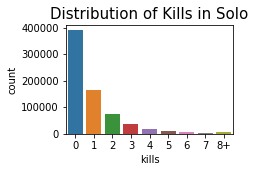

In [12]:
feature = "kills"
# solo
feature_distribution(solos, feature, "solo")

The averge kills by a player is: 0.9133, and 99% of players have 7.0 kills or less in duo mode.


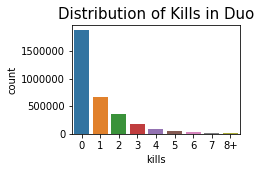

In [13]:
# duo
feature_distribution(duos, feature, "duo")

The averge kills by a player is: 1.0005, and 99% of players have 9.0 kills or less in squad mode.


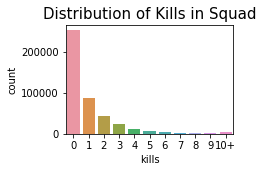

In [14]:
# squad
feature_distribution(squads, feature, "squad")

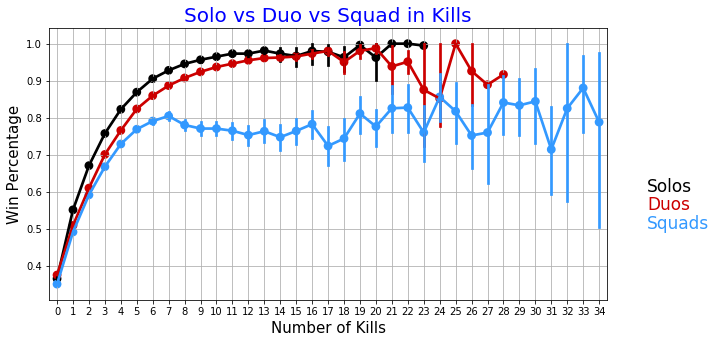

In [15]:
winrate_feature_comparison(solos, duos, squads, feature)

<h2>- DBNOs</h2>

In [16]:
feature = "DBNOs"
# solo
#feature_distribution(solos, feature, "solo")# Knock down is meaningless in solo mode 

The averge DBNOs by a player is: 0.7696, and 99% of players have 5.0 DBNOs or less in duo mode.


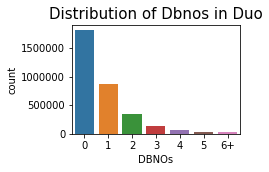

In [17]:
# duo
feature_distribution(duos, feature, "duo")

The averge DBNOs by a player is: 0.8840, and 99% of players have 6.0 DBNOs or less in squad mode.


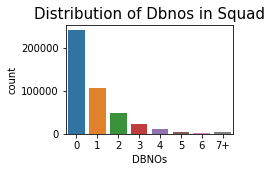

In [18]:
# squad
feature_distribution(squads, feature, "squad")

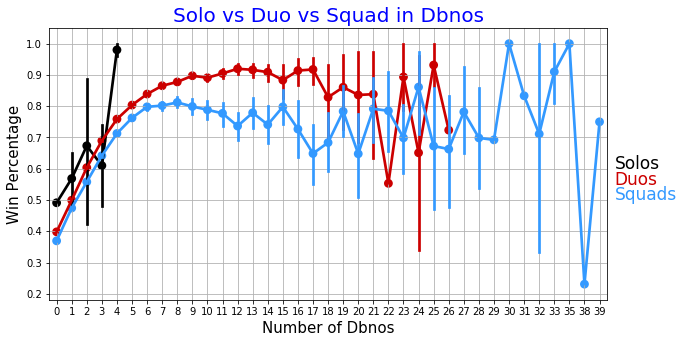

In [19]:
winrate_feature_comparison(solos, duos, squads, feature)

<h2>- heals, boosts</h2>

The averge heals by a player is: 1.0191, and 99% of players have 11.0 heals or less in solo mode.


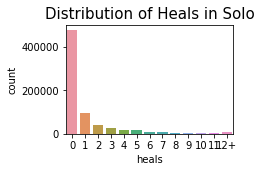

In [20]:
feature = "heals"
# solo
feature_distribution(solos, feature, "solo")

The averge heals by a player is: 1.4224, and 99% of players have 12.0 heals or less in duo mode.


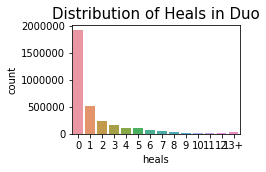

In [21]:
# duo
feature_distribution(duos, feature, "duo")

The averge heals by a player is: 1.5437, and 99% of players have 13.0 heals or less in squad mode.


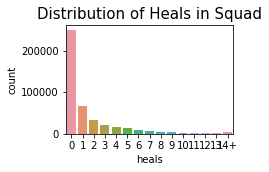

In [22]:
# squad
feature_distribution(squads, feature, "squad")

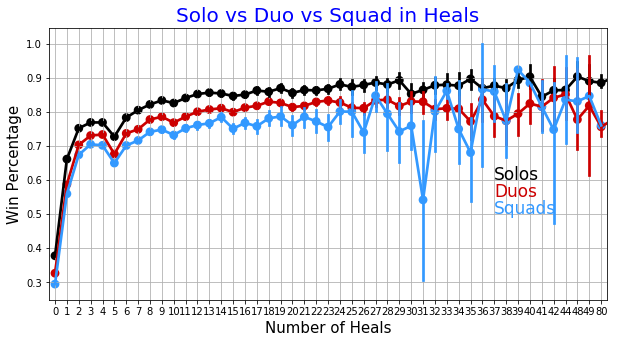

In [23]:
winrate_feature_comparison(solos, duos, squads, feature)

The averge boosts by a player is: 1.0694, and 99% of players have 8.0 boosts or less in solo mode.


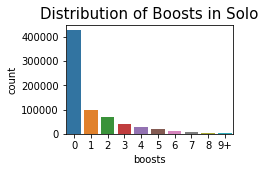

In [24]:
feature = "boosts"
# solo
feature_distribution(solos, feature, "solo")

The averge boosts by a player is: 1.1083, and 99% of players have 7.0 boosts or less in duo mode.


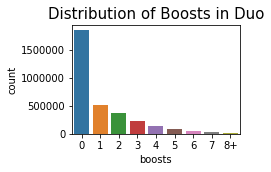

In [25]:
# duo
feature_distribution(duos, feature, "duo")

The averge boosts by a player is: 1.1550, and 99% of players have 7.0 boosts or less in squad mode.


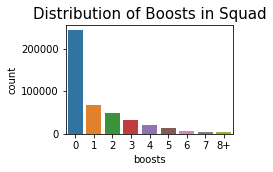

In [26]:
# squad
feature_distribution(squads, feature, "squad")

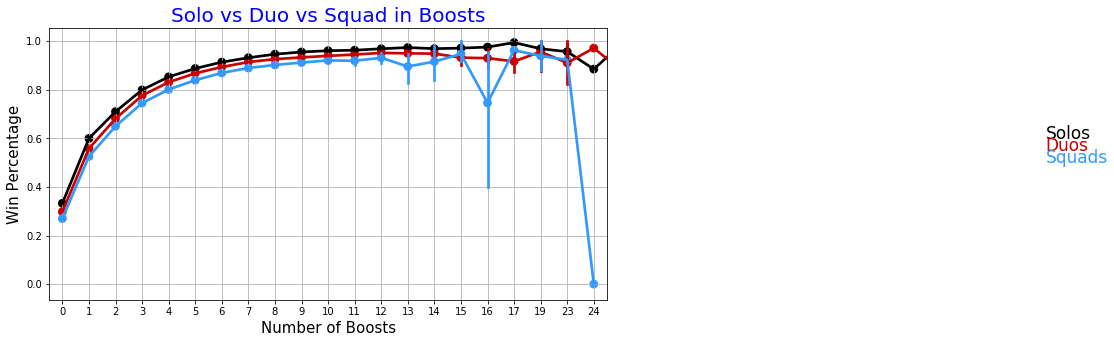

In [27]:
winrate_feature_comparison(solos, duos, squads, feature)

<h2>- Correlations </h2>

The top 5 correlation factor with win percentage is ['walkDistance' 'weaponsAcquired' 'boosts' 'damageDealt' 'kills'] in solo mode.


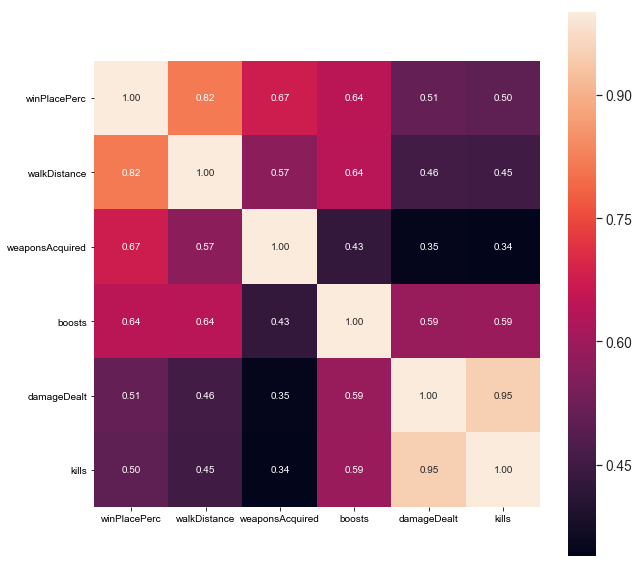

In [28]:
top_N_correlation(solos, 5, 'solo')

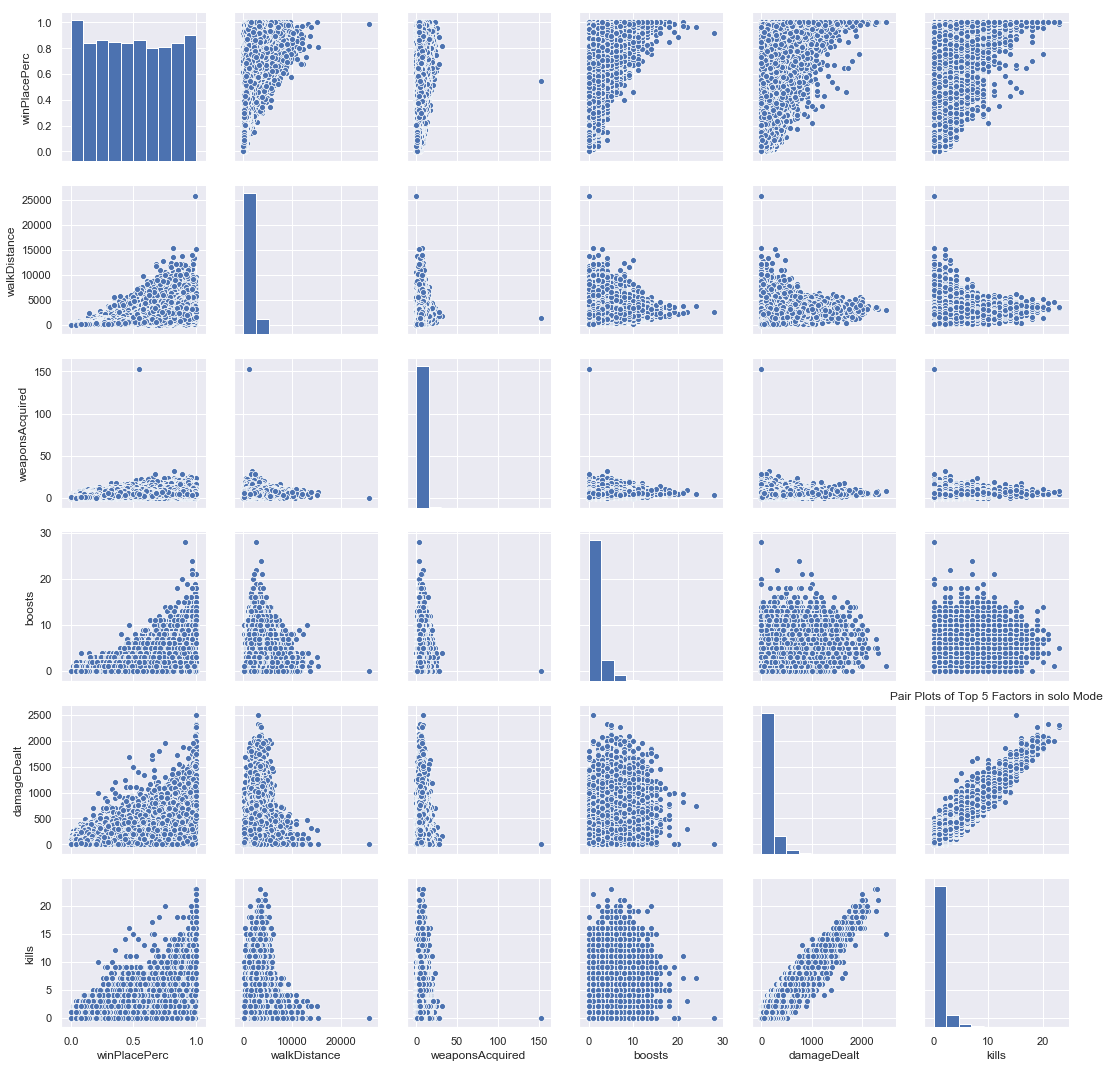

In [29]:
correlation_pair_plot(solos, 5, "solo")

The top 5 correlation factor with win percentage is ['walkDistance' 'boosts' 'weaponsAcquired' 'damageDealt' 'heals'] in duo mode.


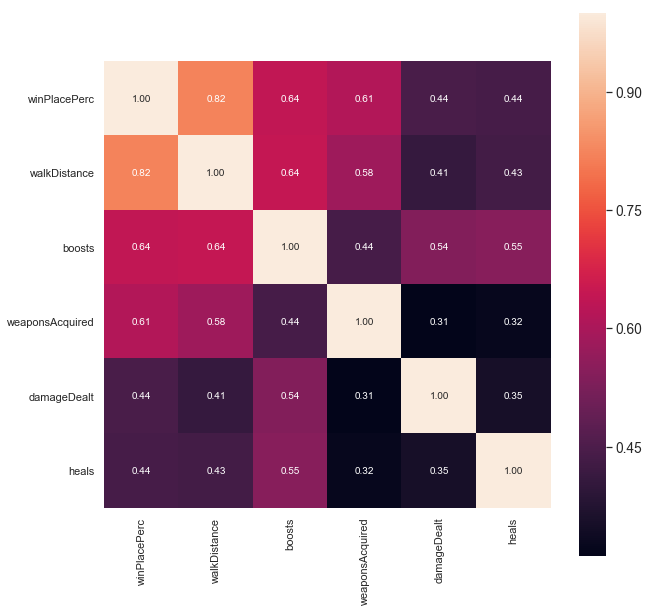

In [30]:
top_N_correlation(duos, 5, 'duo')

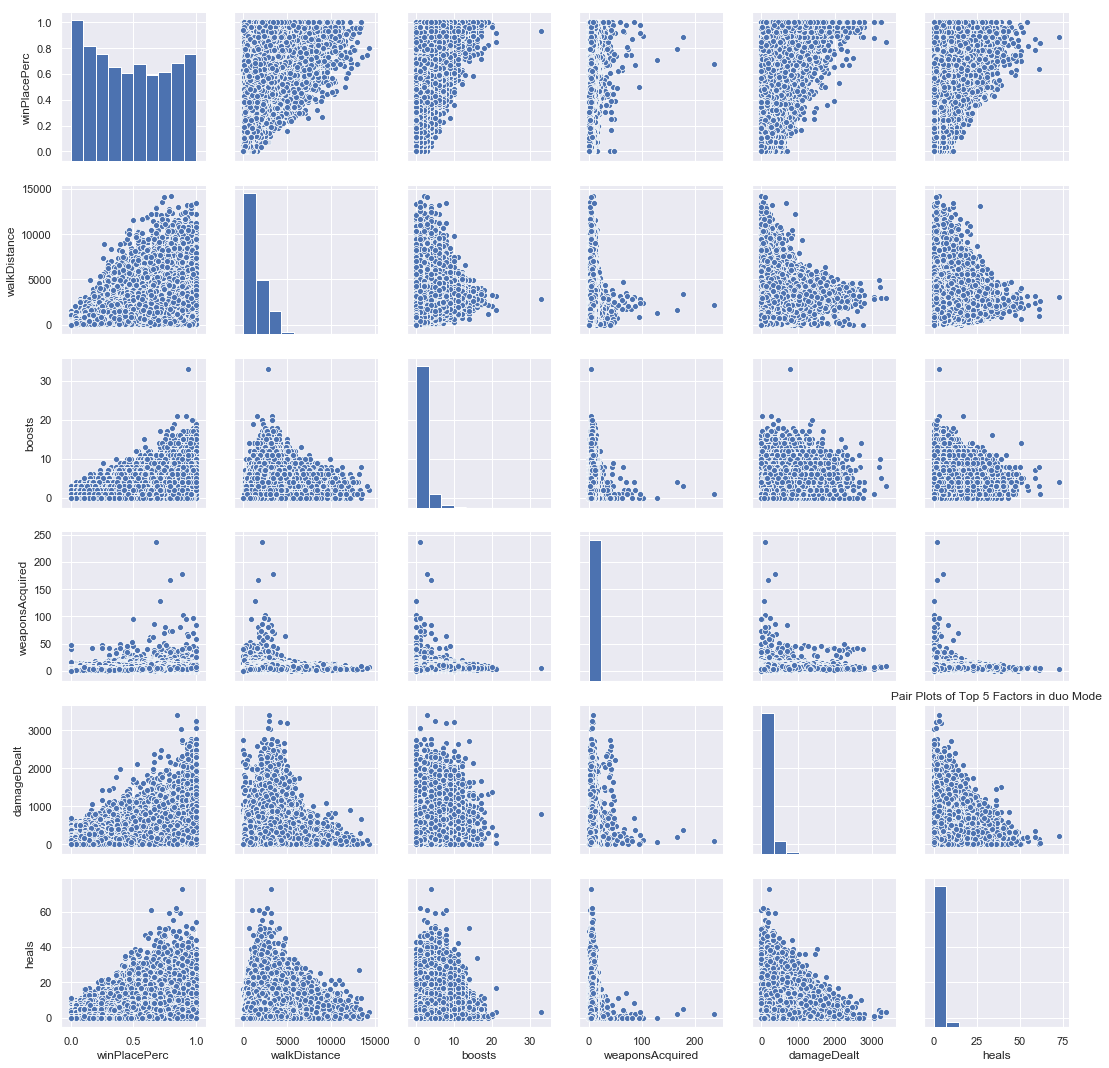

In [31]:
correlation_pair_plot(duos, 5, 'duo')

The top 5 correlation factor with win percentage is ['walkDistance' 'boosts' 'heals' 'weaponsAcquired' 'longestKill'] in squad mode.


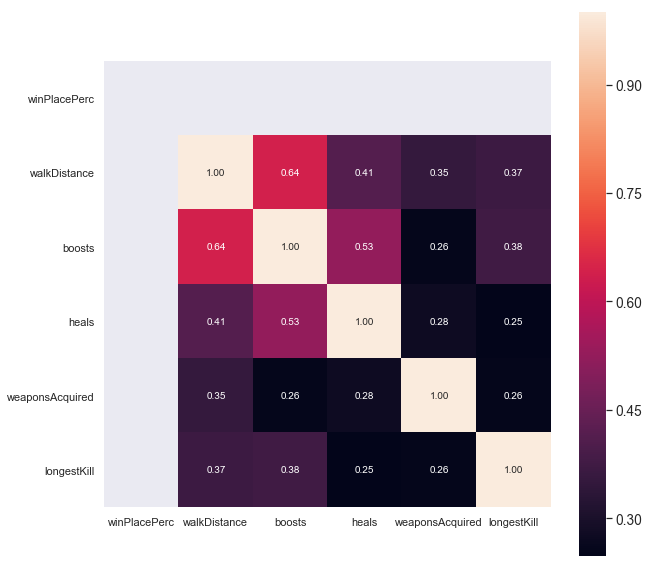

In [32]:
top_N_correlation(squads, 5, 'squad')

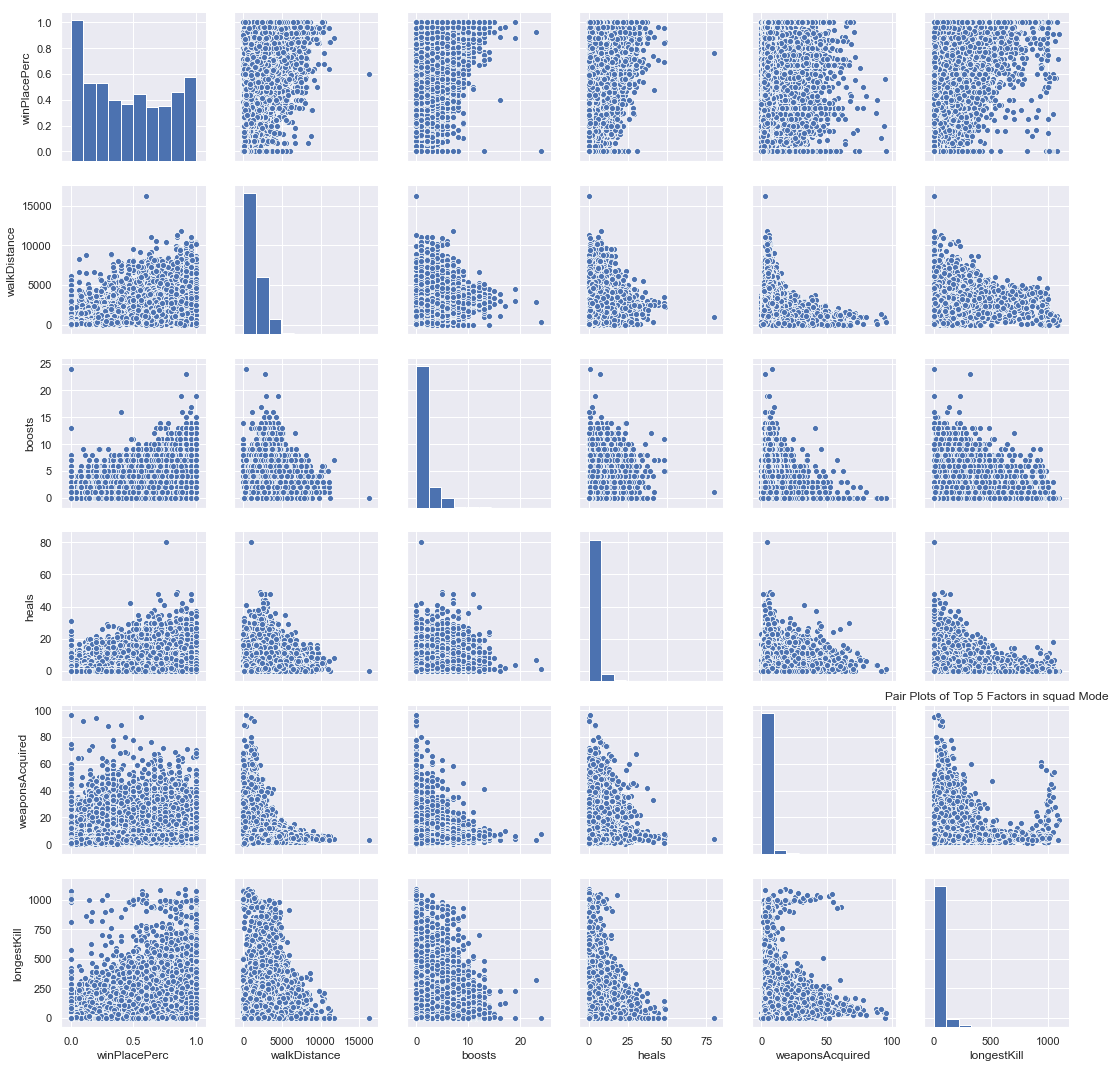

In [33]:
correlation_pair_plot(squads, 5, 'squad')

<h1> Part 3 - Placement Prediction Model Training and Importance Visualization</h1>

In [34]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

In [42]:
def model_predict(data, model, fold_nums, params):
    # Divide in training/validation
    print("Starting LightGBM. Train shape: {}".format(data.shape))

    # Create arrays and dataframes to store results
    predictions = np.zeros(data.shape[0])
    feature_importance = pd.DataFrame()

    drop_features = ['Id', 'groupId', 'matchId', 'matchType', 'winPlacePerc']    
    features = [f for f in data.columns if f not in drop_features]

    # Create model
    if fold_nums == 1:
        train_x, valid_x, train_y, valid_y = train_test_split(data[features], data['winPlacePerc'], test_size=0.2, random_state=1001)
        model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
            eval_metric= 'mae', verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'])

        predictions = model.predict(data[features])

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = 1
        feature_importance = pd.concat([feature_importance, fold_importance_df], axis=0)
        print('MAE : %.6f' % (mean_absolute_error(data['winPlacePerc'], predictions)))
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    # Cross validation model
    elif fold_nums > 1:
        folds = KFold(n_splits= fold_nums, shuffle=True, random_state=1001)
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(data[features], data['winPlacePerc'])):
            train_x, train_y = data[features].iloc[train_idx], data['winPlacePerc'].iloc[train_idx]
            valid_x, valid_y = data[features].iloc[valid_idx], data['winPlacePerc'].iloc[valid_idx]

            model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                      eval_metric= 'mae', verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'])

            predictions[valid_idx] = model.predict(valid_x)

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = features
            fold_importance_df["importance"] = model.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance = pd.concat([feature_importance, fold_importance_df], axis=0)
            print('Fold %2d MAE : %.6f' % (n_fold + 1, mean_absolute_error(valid_y, predictions[valid_idx])))
            del train_x, train_y, valid_x, valid_y
            gc.collect()

    print('Full MAE score %.6f' % mean_absolute_error(data['winPlacePerc'], predictions))
    return model, predictions, feature_importance

In [43]:
def plot_importance(feature_importance, matchtype):
    cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds) - {}'.format(matchtype))
    plt.tight_layout()

In [44]:
params = {
    'num_leaves': 144,
    'learning_rate': 0.1,
    'n_estimators': 800,
    'max_depth':12,
    'max_bin':55,
    'bagging_fraction':0.8,
    'bagging_freq':5,
    'feature_fraction':0.9,
    'verbose':50, 
    'early_stopping_rounds':100
    }

# LightGBM parameters
init_model= lgb.LGBMRegressor(num_leaves=params['num_leaves'], learning_rate=params['learning_rate'], 
                    n_estimators=params['n_estimators'], max_depth=params['max_depth'],
                    max_bin = params['max_bin'], bagging_fraction = params['bagging_fraction'], 
                    bagging_freq = params['bagging_freq'], feature_fraction = params['feature_fraction'],
                   )


Starting LightGBM. Train shape: (709015, 29)
Training until validation scores don't improve for 100 rounds
[50]	training's l1: 0.0408163	training's l2: 0.00324073	valid_1's l1: 0.0411382	valid_1's l2: 0.00330545
[100]	training's l1: 0.0394683	training's l2: 0.00303354	valid_1's l1: 0.0401377	valid_1's l2: 0.00316226
[150]	training's l1: 0.0388471	training's l2: 0.00293268	valid_1's l1: 0.039855	valid_1's l2: 0.00312263
[200]	training's l1: 0.0383728	training's l2: 0.00285619	valid_1's l1: 0.0397252	valid_1's l2: 0.00310523
[250]	training's l1: 0.0379434	training's l2: 0.00279064	valid_1's l1: 0.0396013	valid_1's l2: 0.00308908
[300]	training's l1: 0.0375523	training's l2: 0.00273026	valid_1's l1: 0.0395321	valid_1's l2: 0.00308089
[350]	training's l1: 0.0371879	training's l2: 0.00267518	valid_1's l1: 0.0394539	valid_1's l2: 0.00307155
[400]	training's l1: 0.036848	training's l2: 0.0026257	valid_1's l1: 0.0393959	valid_1's l2: 0.00306559
[450]	training's l1: 0.0364973	training's l2: 0.0

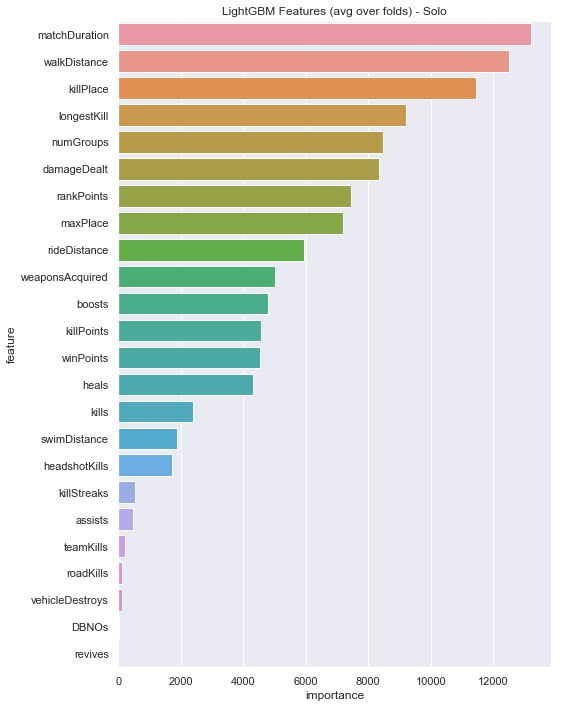

In [45]:
# solo
solo_trained_model, solo_predicitons, solo_feature_importance = model_predict(solos, init_model, fold_nums=1, params=params)
plot_importance(solo_feature_importance, "Solo")

Starting LightGBM. Train shape: (3287713, 29)
Training until validation scores don't improve for 100 rounds
[50]	training's l1: 0.0602955	training's l2: 0.00684981	valid_1's l1: 0.0604858	valid_1's l2: 0.00690592
[100]	training's l1: 0.0587446	training's l2: 0.0065354	valid_1's l1: 0.0590628	valid_1's l2: 0.0066282
[150]	training's l1: 0.0583148	training's l2: 0.00643568	valid_1's l1: 0.0587548	valid_1's l2: 0.00656572
[200]	training's l1: 0.0580571	training's l2: 0.00637433	valid_1's l1: 0.0586143	valid_1's l2: 0.00653842
[250]	training's l1: 0.0578456	training's l2: 0.00632162	valid_1's l1: 0.0585231	valid_1's l2: 0.00651856
[300]	training's l1: 0.0576497	training's l2: 0.0062734	valid_1's l1: 0.0584411	valid_1's l2: 0.00650204
[350]	training's l1: 0.0574792	training's l2: 0.00623202	valid_1's l1: 0.0583813	valid_1's l2: 0.00649046
[400]	training's l1: 0.0573155	training's l2: 0.0061903	valid_1's l1: 0.0583351	valid_1's l2: 0.00648054
[450]	training's l1: 0.0571575	training's l2: 0.0

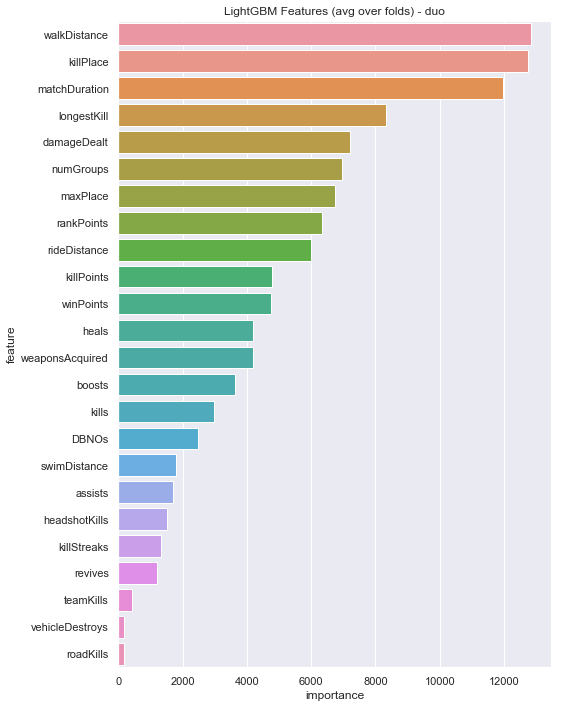

In [46]:
# duo
duo_trained_model, duo_predicitons, duo_feature_importance = model_predict(duos, init_model, fold_nums=1, params=params)
plot_importance(duo_feature_importance, "duo")

Starting LightGBM. Train shape: (440288, 29)
Training until validation scores don't improve for 100 rounds
[50]	training's l1: 0.0771016	training's l2: 0.0118501	valid_1's l1: 0.0781281	valid_1's l2: 0.0123661
[100]	training's l1: 0.0737293	training's l2: 0.0107793	valid_1's l1: 0.0760015	valid_1's l2: 0.01189
[150]	training's l1: 0.0721141	training's l2: 0.0101953	valid_1's l1: 0.0753949	valid_1's l2: 0.0117386
[200]	training's l1: 0.0708245	training's l2: 0.00976395	valid_1's l1: 0.0750261	valid_1's l2: 0.0116565
[250]	training's l1: 0.0697633	training's l2: 0.00940419	valid_1's l1: 0.0748695	valid_1's l2: 0.0116431
[300]	training's l1: 0.0687826	training's l2: 0.00908636	valid_1's l1: 0.0746775	valid_1's l2: 0.0116146
[350]	training's l1: 0.0678781	training's l2: 0.00882013	valid_1's l1: 0.0745473	valid_1's l2: 0.0115917
[400]	training's l1: 0.0669931	training's l2: 0.00855626	valid_1's l1: 0.0744101	valid_1's l2: 0.0115672
[450]	training's l1: 0.0662039	training's l2: 0.00833655	va

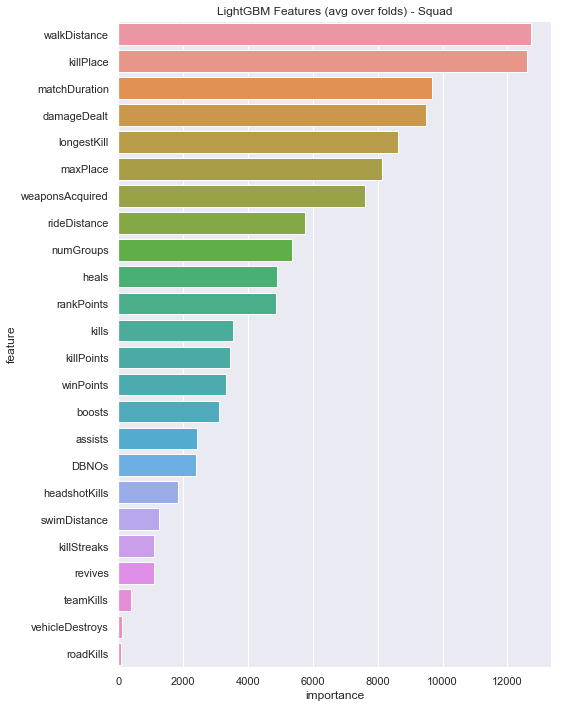

In [48]:
# squads
squad_trained_model, squad_predicitons, squad_feature_importance = model_predict(squads.dropna(axis=0), init_model, fold_nums=1, params=params)
plot_importance(squad_feature_importance, "Squad")